## **Northeastern SMILE Lab - Recognizing Faces in the Wild**

## Background

The SMILE Lab at Northeastern focuses on the frontier research of applied machine learning, social media analytics, human-computer interaction, and high-level image and video understanding. Their research is driven by the explosion of diverse multimedia from the Internet, including both personal and publicly available photos and videos. They start by treating fundamental theory from learning algorithms as the soul of machine intelligence and arm it with visual perception.

Northeastern University has been developing an automatic kinship classifier since 2010. However, the widespread adoption of this technology has been hindered by two primary factors:

- Data Limitations: Existing image databases for kinship recognition are insufficient in size and diversity to accurately represent global familial relationships.

- Model Complexity: The complex interplay of genetic and environmental factors influencing facial features necessitates a more advanced model than traditional computer vision algorithms, which are typically designed for higher-level tasks like facial recognition or object classification.

## Objective

Using the provided competition data, the following model predicts the probability of two individuals being related (1) based solely on a pair of facial images. 

## **Preliminaries**: Install the following Python modules.

In [ ]:
# If they are not already installed, this cell installs the modules used in this solution.
%pip install collections
%pip install glob
%pip install kaggle
%pip install matplotlib
%pip install os
%pip install pandas
%pip install sklearn
%pip install torch
%pip install torch.nn
%pip install torch.optim
%pip install torchvision.datasets
%pip install torchvision.transforms
%pip install zipfile

## **Step 1**: Download the official Kaggle competition (FIW) data.

***Before executing the following cell***, please review section 7 of the rules: https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/rules#7-competition-data. 

Note that all usages of FIW data should cite the following papers:

*Joseph P Robinson, Ming Shao, Hongfu Liu, Yue Wu, Timothy Gillis, and Yun Fu. "Visual Kinship Recognition of Families In the Wild" IEEE TPAMI Special Edition: Computational Face (2018).
Joseph P Robinson, Ming Shao, Handong Zhao, Yue Wu, Timothy Gillis, Yun Fu. "Recognizing Families In the Wild (RFIW): Data Challenge Workshop in conjunction with ACM MM 2017," ACM Multimedia Conference: Workshop on RFIW (2017).
Shuyang Wang, Joseph P Robinson, and Yun Fu. “Kinship Verification on Families in the Wild with Marginalized Denoising Metric Learning,” in IEEE Automatic Face and Gesture Recognition (2017).
Joseph P Robinson, Ming Shao, Yue Wu, and Yun Fu. “Families In the Wild (FIW): large-scale kinship image database and benchmarks." in ACM on Multimedia Conference (2016).*

In [2]:
download_path = '_provided-data' # Intermediate directories are excluded recursively via. .gitignore (i.e., '_*/').
competition = 'recognizing-faces-in-the-wild' # Hosted here: https://www.kaggle.com/c/recognizing-faces-in-the-wild

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.makedirs(download_path, exist_ok=True)
print('Downloading ' + competition + ' provided data into ' + download_path)
api = KaggleApi()
api.authenticate()
api.competition_download_files(competition, path = download_path)

In [3]:
import os
import zipfile

def unzip(zip_path):
    dest_dir = '_' + os.path.basename(zip_path)[:-4]
    if (not os.path.exists(dest_dir)):
        os.makedirs(dest_dir, exist_ok=True)
        print('Decompressing ' + zip_path + ' into ' + dest_dir)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dest_dir)
    print(dest_dir + '/')
    print(os.listdir(dest_dir))
    return dest_dir

print('Decompressing ' + competition + ' provided data:')
dataset_path = unzip(download_path + '/' + competition + '.zip')
training_image_path = unzip(dataset_path + '/train-faces.zip')
testing_image_path = unzip(dataset_path + '/test-faces.zip')

Decompressing recognizing-faces-in-the-wild provided data:
_recognizing-faces-in-the-wild/
['README.md', 'sample_submission.csv', 'test-faces.zip', 'test-private-faces.zip', 'test-private-labels.zip', 'test-private-lists.zip', 'test-public-faces.zip', 'test-public-lists.zip', 'test.zip', 'train-faces.zip', 'train.zip', 'train_relationships.csv']
_train-faces/
['F0001', 'F0002', 'F0003', 'F0004', 'F0005', 'F0006', 'F0007', 'F0008', 'F0011', 'F0012', 'F0015', 'F0016', 'F0017', 'F0018', 'F0020', 'F0021', 'F0022', 'F0023', 'F0024', 'F0026', 'F0027', 'F0028', 'F0029', 'F0030', 'F0031', 'F0032', 'F0033', 'F0034', 'F0035', 'F0036', 'F0038', 'F0039', 'F0040', 'F0041', 'F0042', 'F0043', 'F0044', 'F0045', 'F0046', 'F0047', 'F0048', 'F0050', 'F0052', 'F0053', 'F0054', 'F0055', 'F0056', 'F0057', 'F0060', 'F0061', 'F0062', 'F0063', 'F0064', 'F0065', 'F0066', 'F0067', 'F0068', 'F0069', 'F0070', 'F0071', 'F0072', 'F0074', 'F0075', 'F0077', 'F0078', 'F0079', 'F0080', 'F0081', 'F0082', 'F0083', 'F0086'

## **Step ?**: Load the labeled (relational) data.
The _train_relationships.csv_ encodes (ground truth) kinship relations between pairs of people. 

In [4]:
import pandas
relations_csv_path = dataset_path + '/train_relationships.csv'
print('Loading ' + relations_csv_path)
relations_df = pandas.read_csv(relations_csv_path, delimiter=',', header='infer')
relations_df.head()

Loading _recognizing-faces-in-the-wild/train_relationships.csv


,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


## **Step ?**: Clean labeled data
To improve the training efficiency, entries in the ground truth relations dataframe are removed if either person does not have valid image data in train-faces\...

In [5]:
from collections import defaultdict
import glob
import pandas

relations_csv_path = dataset_path + '/train_relationships.csv'
print('Loading ' + relations_csv_path)
relations_df = pandas.read_csv(relations_csv_path, delimiter=',', header='infer')

# Create a dictionary to lookup image files for each member
family_dict = defaultdict(list)
for family in glob.glob(training_image_path + '*'):
    for member in glob.glob(family + '/*'):
        for image_path in glob.glob(member + '/*'):
            member = member.split('\\')[-1]
            image_path = image_path.split('\\')[-1]
            family_dict[member].append(image_path)

print('Images found for members of ' + str(len(family_dict.items())) + ' total families.')
for key, value in list(family_dict.items())[:5]:
    print(str(key) + ': ' + str(value) + ',')
    
# Remove entries which do not exist in the training set
print('The original ground truth relations data contains ' + str(len(relations_df)) + ' pairs.')
print(relations_df)

print('Checking for missing relation image data.')
fam_keys = family_dict.keys()
missing_relations_list = []
for index, row in relations_df.iterrows():
    split1 = row.p1.split('/')
    split2 = row.p2.split('/')
    p1fam = split1[0]
    p2fam = split2[0]
    if (p1fam not in fam_keys or p2fam not in fam_keys):
        missing_relations_list.append(index)
        continue
    p1member = split1[1]
    p2member = split2[1]
    if (p1member not in family_dict[p1fam] or p2member not in family_dict[p2fam]):
        missing_relations_list.append(index)
        continue
    images1 = os.listdir(training_image_path + '/' + p1fam + '/' + p1member)
    images2 = os.listdir(training_image_path + '/' + p2fam + '/' + p2member)
    if (len(images1) == 0 or len(images2) == 0):
        missing_relations_list.append(index)
        continue
if (missing_relations_list.count):
    relations_df = relations_df.drop(missing_relations_list)
    print(str(len(missing_relations_list)) + ' pairs were removed due to missing data.')
    print(relations_df)
else:
    print('All relations were found to have valid image data.')


Loading _recognizing-faces-in-the-wild/train_relationships.csv
Images found for members of 786 total families.
F0001: ['MID1', 'MID2', 'MID3', 'MID4'],
F0002: ['MID1', 'MID2', 'MID3'],
F0003: ['MID1', 'MID2', 'MID3', 'MID4'],
F0004: ['MID1', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6', 'MID7'],
F0005: ['MID1', 'MID2', 'MID3'],
The original ground truth relations data contains 3598 pairs.
              p1          p2
0     F0002/MID1  F0002/MID3
1     F0002/MID2  F0002/MID3
2     F0005/MID1  F0005/MID2
3     F0005/MID3  F0005/MID2
4     F0009/MID1  F0009/MID4
...          ...         ...
3593  F1000/MID5  F1000/MID8
3594  F1000/MID5  F1000/MID9
3595  F1000/MID6  F1000/MID9
3596  F1000/MID7  F1000/MID8
3597  F1000/MID7  F1000/MID9

[3598 rows x 2 columns]
Checking for missing relation image data.
1108 pairs were removed due to missing data.
              p1          p2
0     F0002/MID1  F0002/MID3
1     F0002/MID2  F0002/MID3
2     F0005/MID1  F0005/MID2
3     F0005/MID3  F0005/MID2
29    F00

## **Step ?**: Compose the data (loader) to be used for training

## **Step ?**: Build a list of ground truth members and images

In [7]:

import itertools
import random

# Create a list of all of the members in the relations data
members = []
for member in relations_df.values:
    if (member[0] not in members):
        members.append(member[0])
    if (member[1] not in members):
        members.append(member[1])
members.sort()
print(str(len(members)) + ' total members in the training set:')
print(members)

# Create a list of the corresponding images
member_images = dict()
for member in members:
    set = os.listdir(training_image_path + '/' + member)
    if (len(set) > 0):
        image_set = []
        for image in set:
            image_set.append(member + '/' + image)
        member_images[member] = image_set
print(member_images)

training_data_positives = []
# Add the related image pairs
for index, row in relations_df.iterrows():
    p1 = row.p1
    p2 = row.p2
    p1_images = list(member_images[p1])
    p2_images = list(member_images[p2])
    for image1, image2 in itertools.product(p1_images, p2_images):
        training_data_positives.append([image1, image2, 1.0])
print('Training data contains ' + str(len(training_data_positives)) + ' (positive) pairs.')

# Add the unrelated image pairs
training_data_negatives = []
index = 0
while index < len(training_data_positives):
    p1 = random.choice(members)
    p2 = random.choice(members)
    if (p1 == p2):
        continue # try again
    p1_images = list(member_images[p1])
    p2_images = list(member_images[p2])
    for image1, image2 in itertools.product(p1_images, p2_images):
        training_data_negatives.append([image1, image2, 0.0])
        index = index + 1
print('Training data contains ' + str(len(training_data_negatives)) + ' (negative) pairs.')

# randomize the samples
random.shuffle(training_data_positives)
random.shuffle(training_data_negatives)

# Use a roughly equal amount of both for trainings
approx_half = 200#0000
if (approx_half > len(training_data_positives)):
    approx_half = len(training_data_positives)
training_data = random.sample(training_data_positives, approx_half)
training_data = training_data + random.sample(training_data_negatives, approx_half)
random.shuffle(training_data)

print('Training data contains ' + str(len(training_data)) + ' pairs.')
training_data_positives[:5]

1727 total members in the training set:
['F0002/MID1', 'F0002/MID2', 'F0002/MID3', 'F0005/MID1', 'F0005/MID2', 'F0005/MID3', 'F0016/MID1', 'F0016/MID2', 'F0016/MID3', 'F0016/MID4', 'F0016/MID5', 'F0017/MID1', 'F0017/MID2', 'F0017/MID3', 'F0017/MID4', 'F0017/MID5', 'F0017/MID6', 'F0017/MID7', 'F0020/MID1', 'F0020/MID10', 'F0020/MID11', 'F0020/MID2', 'F0020/MID3', 'F0020/MID5', 'F0020/MID6', 'F0020/MID7', 'F0020/MID8', 'F0020/MID9', 'F0022/MID1', 'F0022/MID2', 'F0022/MID3', 'F0022/MID4', 'F0022/MID5', 'F0023/MID1', 'F0023/MID2', 'F0023/MID3', 'F0023/MID4', 'F0023/MID5', 'F0023/MID6', 'F0024/MID1', 'F0024/MID2', 'F0024/MID3', 'F0024/MID4', 'F0024/MID5', 'F0030/MID1', 'F0030/MID2', 'F0030/MID3', 'F0030/MID4', 'F0031/MID1', 'F0031/MID2', 'F0031/MID3', 'F0031/MID4', 'F0031/MID5', 'F0036/MID1', 'F0036/MID2', 'F0036/MID3', 'F0036/MID4', 'F0036/MID5', 'F0036/MID6', 'F0036/MID7', 'F0038/MID1', 'F0038/MID2', 'F0038/MID3', 'F0038/MID4', 'F0038/MID5', 'F0038/MID6', 'F0039/MID1', 'F0039/MID4', 'F004

[['F0655/MID3/P06886_face2.jpg', 'F0655/MID2/P06877_face1.jpg', 1.0],
 ['F0376/MID3/P10623_face1.jpg', 'F0376/MID1/P10642_face2.jpg', 1.0],
 ['F0601/MID6/P06284_face1.jpg', 'F0601/MID7/P11976_face2.jpg', 1.0],
 ['F0601/MID3/P06300_face2.jpg', 'F0601/MID2/P06267_face1.jpg', 1.0],
 ['F0155/MID2/P01662_face1.jpg', 'F0155/MID3/P01665_face2.jpg', 1.0]]

In [ ]:
# TODO Add negative pairs to the training data

In [ ]:
'''
import random

# Use a a portion of the images for training (training_images)...
training_images = random.sample(image_set, int(len(image_set)               -320))
print(str(len(training_images)) + ' images in training_images')
training_images.sort()
print('Showing the first three (sorted):')
print(training_images[:3])
print('Showing the first three (after shuffling):')
random.shuffle(training_images)
print(training_images[:3])

# ...and the remaining for testing (test_images).
test_images = [x for x in image_set if x not in training_images]
print(str(len(test_images)) + ' images in test_images')
print('Showing the first three (sorted):')
print(test_images[:3])
random.shuffle(test_images)
print('Showing the first three (after shuffling):')
print(test_images[:3])
'''

## **Step ?**: Show a random selection of the relations.

              p1          p2
1361  F0390/MID2  F0390/MID8
2508  F0714/MID3  F0714/MID4
214   F0077/MID1  F0077/MID4


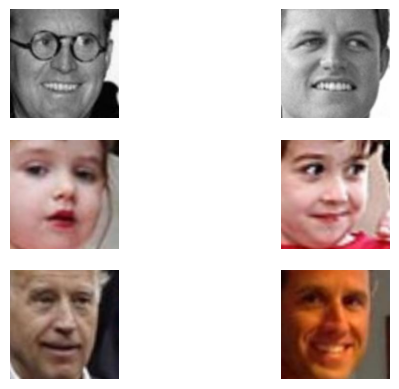

In [8]:
import cv2
import matplotlib.pyplot as plt
from random import choice

SAMPLE_COUNT = 3
samples = relations_df.sample(SAMPLE_COUNT)
print(samples)

f, ax = plt.subplots(SAMPLE_COUNT, 2)
f.patch.set_alpha(0) # Transparent background
for a in ax.flat:
    a.axis('off')
i = 0
for member in samples.values:
    img1 = training_image_path + '/' + member[0] + '/' \
        + choice(os.listdir(training_image_path + '/' + member[0]))
    img2 = training_image_path + '/' + member[1] + '/'  \
        + choice(os.listdir(training_image_path + '/' + member[1]))
    rgb1 = cv2.cvtColor(cv2.imread(img1), cv2.COLOR_BGR2RGB)
    rgb2 = cv2.cvtColor(cv2.imread(img2), cv2.COLOR_BGR2RGB)
    ax[i][0].imshow(rgb1, cmap = plt.cm.Spectral)
    ax[i][1].imshow(rgb2, cmap = plt.cm.Spectral)  
    i = i + 1

## **Step ?**: Train the model

The training process:

1. Pass the image pair through the network.
2. Calculate the loss.
3. Back propagate the loss to calculate the gradients.
4. Update the weights using an optimizer (Adam).

In [9]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

class ImagePairDataset(Dataset):
    def __init__(self, data):
        self.image_pairs = [sublist[:-1] for sublist in data]
        self.labels = torch.tensor([sublist[-1] for sublist in data], dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img0 = Image.open('_train-faces/' + self.image_pairs[idx][0]).convert("L")
        img1 = Image.open('_train-faces/' + self.image_pairs[idx][1]).convert("L")
        transform = transforms.Compose([transforms.Resize((96,96)),
                                        transforms.ToTensor()])
        img0 = transform(img0)
        img1 = transform(img1)
        return torch.tensor(img0), torch.tensor(img1), torch.tensor(self.labels[idx])

dataset_tensor = ImagePairDataset(training_data)
print('The dataset_tensor contains ' + str(len(dataset_tensor)) + ' samples.')

# Create a data loader to iterate over the dataset_tensor in batches
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=False)#=True)
print('The dataloader contains ' + str(len(dataloader)) + ' batches.')


The dataset_tensor contains 400 samples.
The dataloader contains 13 batches.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Convolutional layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Define the contrastive loss function
def contrastive_loss(output1, output2, label):
    euclidean_distance = torch.sqrt(torch.sum((output1-output2)**2, dim=1, keepdim=True))
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(2-euclidean_distance, min=0.0), 2))
    return loss_contrastive

# Hyperparameters
num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the network
model = SiameseNetwork()
criterion = contrastive_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Training loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for i, (data1, data2, label) in enumerate(dataloader):
        #print(data1, data2, label)
        data1, data2, label = data1.to(device), data2.to(device), label.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data1.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch Loss: {epoch_loss:.4f}')

# Training
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train(model, dataloader, criterion, optimizer, device)

In [ ]:
# Store the (trained) model to a file.
torch.save(model.state_dict(),'siamese.pth')

In [12]:

# Load the (trained) model to a file.
model.load_state_dict(torch.load('siamese.pth'))

C:\Users\jplumb\AppData\Local\Temp\ipykernel_11540\3768088402.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('siamese.pth'))


<All keys matched successfully>

In [13]:
def IsRelated(image1, image2, model):
    img1 = Image.open(image1).convert("L")
    img2 = Image.open(image2).convert("L")
    transform = transforms.Compose([transforms.Resize((96,96)),
                                    transforms.ToTensor()])
    img1 = transform(img1)
    img2 = transform(img2)
    img1 = img1.unsqueeze(0)
    img2 = img2.unsqueeze(0)
    output1, output2 = model(img1, img2)
    euclidean_distance = torch.sqrt(torch.sum((output1-output2)**2, dim=1, keepdim=True))
    return euclidean_distance.item()

print("Kinship probability of known kin {}".format(IsRelated('_train-faces/F0601/MID3/P06300_face2.jpg', '_train-faces/F0601/MID2/P06267_face1.jpg', model)))
#print("Kinship probability of known non-kin {}".format(IsRelated('nk1.jpg', 'nk2.jpg', model)))

Kinship probability of known kin 0.8302969336509705


## **Step ?**: Test the model

In [140]:
import itertools

MODEL = True
if (MODEL):
    # Create a list of all of the image pairs in the test-faces data
    test_pairs = list(itertools.combinations(os.listdir(testing_image_path), 2))
else:
    # For now, use a portion of the ground truth relations data for testing
    test_pairs = list(itertools.combinations(test_images, 2))
    
    # Remove invalid pairs (same member)
    invalid_pairs = []
    i = 0
    for pair in test_pairs:
        person1fam_index = pair[0].find('/')
        person2fam_index = pair[1].find('/')
        person1 = pair[0][:pair[0].find('/', person1fam_index+1)]
        person2 = pair[1][:pair[1].find('/', person2fam_index+1)]
        if (person1 == person2):
            invalid_pairs.append(i)
        i = i + 1
    test_pairs = [x for i, x in enumerate(test_pairs) if i not in invalid_pairs]
    print(str(len(invalid_pairs)) + ' pairs of the same member were removed.')
    
print('There are ' + str(len(test_pairs)) + ' total pairs in the test set.')


There are 11836545 total pairs in the test set.


In [ ]:
# Inference function
def predict_related(img1, img2):
    likelihood = (path1[:path1.find('/')] == path2[:path2.find('/')])
    return int(likelihood)*0.999
    # TODO Once the model is trained, use it instead of the above placeholder
    # TODO Preprocess the images
    output1, output2 = model(img1, img2)
    distance = torch.sqrt(torch.sum( (output1 - output2)**2, dim=1, keepdim = True ))
    return 1-distance
        
results = []
print(len(test_pairs))
for pair in test_pairs:
    person1fam_index = pair[0].find('/')
    person2fam_index = pair[1].find('/')
    person1 = pair[0][:pair[0].find('/', person1fam_index+1)]
    person2 = pair[1][:pair[1].find('/', person2fam_index+1)]
    results.append({'actual':int(isRelated(relations_df, person1, person2)),
                    'prediction':float(predict_related(pair[0], pair[1]))})


results_df = pandas.DataFrame(results)
results_df.describe()

## **Step ?**: Evaluation
Submissions are [evaluated](https://www.kaggle.com/competitions/recognizing-faces-in-the-wild/overview/evaluation) on area under the ROC curve between the predicted probability and the observed target. Not all pairs will be scored.

**Submission File**

For each img_pair in the test set, you must predict a probability for the is_related variable. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg.
The file should contain a header and have the following format:

```
img_pair,is_related
X3Nk6Hfe5x-qcZrTXsfde,0.0
X3Nk6Hfe5x-LD0pWDM8w_,0.0
X3Nk6Hfe5x-PHwuDtHyGp,0.0
X3Nk6Hfe5x-LO6lN_U4ot,0.0
...
```

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# https://en.wikipedia.org/wiki/Receiver_operating_characteristic
def generate_roc_curve(data):
  true_labels = [d['actual'] for d in data]
  predicted_probs = [d['prediction'] for d in data]
  fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  return plt
    
generate_roc_curve(results).show()

In [ ]:
import csv

submission = [['img_pair', 'is_related']]
for pair,result in zip(test_pairs, results):
    submission.append([pair[0] + '-' + pair[1], str(result['prediction'])])
filename = "submission.csv"
with open(filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(submission)
print(f"Saved '{filename}'")

import pandas
print('Loading ' + filename)
submission_df = pandas.read_csv(filename, delimiter=',', header='infer')
submission_df.describe()